# Set Up For Link Margin - Shreya

In [2]:
# Import relevant libraries and such 
import sys
import os
import matplotlib
if 'matplotlib.pyplot' not in sys.modules.keys():
    matplotlib.use("Agg")
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, CubicSpline
# import propagation_lib as prop 

%matplotlib notebook

## Constants ##
ft2m = 0.3048
c_speed = 3.0e8
kB = 1.39e-23

# Standard Link Margin Calculator - Shreya

In [2]:
## Set transmitter parameters -- static portrait of what is happening along the trajectory

ht_rocket=500.0 # height of rocket (in km)
freq = 162.990625e6 # transmit frequency (Hz)
txPwr = 2 # transmit power (in Watts)
Gtx = 2.1 # dBi (1992 ARRL Handbook p.17-18 value for half-wave dipole antenna)
txAng = 45 # misalignment between tx and rx antennas

## Set receiver parameters

# Grx = 2.1 # Rx antenna gain, assumed same as Gtx in an isotropic setting 
Grx = 6.09 # Rx antenna gain, when we introduce the two-element yagi (6.09 dBi = maximum gain)
rxAng = 45 # misalignment between tx and rx antennas
# Bn = 200e3 # Receiver [Noise] Bandwidth (Hz) [used min IF bandwidth specified in RSPduo Datasheet]
Bn = 20.0e3 # Receiver Bandwidth expected given testing at Wallops 

# Receiver Noise Figure
# NFrx_dB = 3.3 # in dB given in RSPduo Datasheet for 100/200MHz operation
NFrx_dB = 0.5 # in dB with a pre-amp
NFrx = 10.0**(NFrx_dB/10) # Convert to dimensionless quantity

## Calculations to find the Recieved Signal (i.e., carrier) Power
# Line-of-sight path length from tx to rx in meters
Rrocket = ht_rocket*1.0e3; Rrocket_mod=None
# # [Opt.] Modify Line-of-sight path length to account for misalignment between tx and rx antennas
# Rrocket_mod = Rrocket/(np.cos(45.*np.pi/180.)*np.cos(45.*np.pi/180.)) 
# Set R to use in path loss calculation 
if Rrocket_mod is None: R=Rrocket
else: R=Rrocket_mod
Lpath = (4.*np.pi*R*freq/c_speed)**2 # Path Loss
Pwr_rx = (txPwr*(10.0**(Gtx/10.)*np.cos(txAng*np.pi/180.)**2)*(10.0**(Grx/10.)*np.cos(rxAng*np.pi/180.)**2))/Lpath # Received Power in Watts at input to receiver (i.e. without LNA gain)

## Calculations to find the Carrier-to-Noise Ratio
# Calculate Noise temperature of reciever (asssuming reference temperature of 290K) [See Sat Comm book p. 111]
Tn = 290*(NFrx-1) 
# Calculate the Carrier-to-Noise Ratio
CNR = Pwr_rx/(kB*Bn*Tn)

print('Frequency = %s MHz; Noise Bandwidth = %s kHz' % (freq/1e6, Bn/1e3))
print('EIRP ~= %.2f W (%.2f dBW)' % (txPwr*10.0**(Gtx/10.), 10*np.log10(txPwr*10.0**(Gtx/10.))))
print('RX (Antenna) Gain ~= %.2f (%.2f dB)\n' % (10.0**(Grx/10), Grx))
print('Antenna Angle Misalignments: TX=%s deg, RX=%s deg' % (txAng, rxAng))
print('Distance of RX from TX: %s km\n' % (int(np.round(R/1e3, decimals=0))))
print('Modified EIRP  ~= %.2f W (%.2f dBW)' % (txPwr*10.0**(Gtx/10.)*np.cos(txAng*np.pi/180.)**2, 10*np.log10(txPwr)+Gtx+20.*np.log10(np.cos(txAng*np.pi/180.))))
print('Modified RX Gain ~= %.2f (%.2f dB)' % (10.0**(Grx/10)*np.cos(rxAng*np.pi/180.)**2, Grx+20*np.log10(np.cos(rxAng*np.pi/180.))))
print('Path Loss ~= %s (%.2f dB)\n' % (np.format_float_scientific(Lpath, precision=2), 10*np.log10(Lpath)))
print('Received Signal Power ~= %s W (%.2f dBW)' % (np.format_float_scientific(Pwr_rx, precision=2), 10*np.log10(Pwr_rx)))
print('Receiver Thermal Noise (pre-Amp) ~= %s W (%.2f dBW)' %(np.format_float_scientific(kB*Bn*Tn, precision=2), 10*np.log10(kB*Bn*Tn)))
print("C/N ~= %.2f (%.2f dB)" % (CNR, 10*np.log10(CNR)))

Frequency = 162.990625 MHz; Noise Bandwidth = 20.0 kHz
EIRP ~= 3.24 W (5.11 dBW)
RX (Antenna) Gain ~= 4.06 (6.09 dB)

Antenna Angle Misalignments: TX=45 deg, RX=45 deg
Distance of RX from TX: 500 km

Modified EIRP  ~= 1.62 W (2.10 dBW)
Modified RX Gain ~= 2.03 (3.08 dB)
Path Loss ~= 1.17e+13 (130.66 dB)

Received Signal Power ~= 2.83e-13 W (-125.48 dBW)
Receiver Thermal Noise (pre-Amp) ~= 9.84e-18 W (-170.07 dBW)
C/N ~= 28751.41 (44.59 dB)


## Two Element Yagi

In [3]:
# modeling two element yagi angular dependence

# Step 1: Define the angles and their corresponding linear values
angles = np.array([0, 15, 30, 45, 75, 90])
linear_values = np.array([10**(0/10), 10**(-1/10), 10**(-2.5/10), 10**(-6/10), 10**(-19/10), 0])

# Step 2: Create the cubic spline interpolation function
# Note: Set 'bc_type' to 'natural' to ensure a more stable interpolation
cubic_spline = CubicSpline(angles, linear_values, bc_type='natural')

# Step 3: Define the new angle range for interpolation
new_angles = np.linspace(0.1, 90, 100)

# Step 4: Interpolate the values using cubic spline
interpolated_linear_values = cubic_spline(new_angles)

# Step 5: Handle small values and convert to dB
# epsilon = 1e-10  # Small value to avoid log(0)
# interpolated_linear_values_safe = np.maximum(interpolated_linear_values, epsilon)
interpolated_db_values = 10 * np.log10(interpolated_linear_values)

# Set interpolated values to -inf where original linear values were zero or negative
# interpolated_db_values[interpolated_linear_values <= 0] = -np.inf

# Step 6: Plotting the results
plt.close()
# plt.plot(angles, 10 * np.log10(linear_values + epsilon), 'o', label='Original dB values')
plt.plot(new_angles, interpolated_db_values, '-', label='Cubic Spline Interpolated dB values')
plt.scatter(angles, 10*np.log10(linear_values))
plt.xlabel('Angle (degrees)')
plt.ylabel('dB')
plt.title('Cubic Spline Interpolation of dB Values')
plt.legend()
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>

C:\Users\skwal\AppData\Local\Temp\ipykernel_29028\3736303930.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(angles, 10*np.log10(linear_values))


# 1. Simple Link Margin Variations -- according to angle/distance/etc - Shreya

In [4]:
## SIMPLY CHANGING ROCKET'S ALTITUDE ALONG TRAJECTORY
    # This assumes a constant 90 degree rx/tx offset -- which is unrealistic but we're just examining parameter space here 

# Create array of rocket altitudes from ground to 500 km 
ht_array = []
for n in range(1, 500, 1):
    ht_array.append(n)
rxAng = 45
txAng = 45
received_array = [] # received power along the trajectory

for x in ht_array:
    ht_rocket = x
    Rrocket = ht_rocket*1.0e3
    if Rrocket_mod is None: R=Rrocket
    
    # Calculate Path Loss + Received Power: 
    Lpath = (4.*np.pi*R*freq/c_speed)
    Pwr_rx = (txPwr*(10.0**(Gtx/10.)*np.cos(txAng*np.pi/180.)**2)*(10.0**(Grx/10.)*np.cos(rxAng*np.pi/180.)**2))/Lpath # Received Power in Watts at input to receiver (i.e. without LNA gain)
    received_array.append(10*np.log10(Pwr_rx))

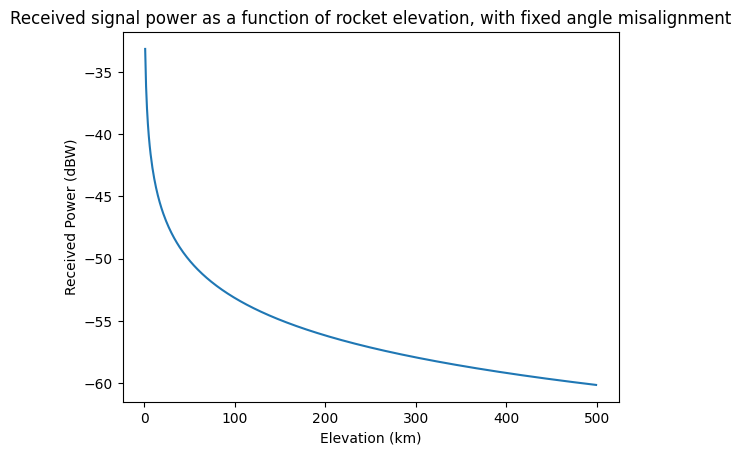

In [35]:
# Plotting above cell 
plt.close()
plt.plot(ht_array, received_array)
plt.title("Received signal power as a function of rocket elevation, with fixed angle misalignment")
plt.xlabel("Elevation (km)")
plt.ylabel("Received Power (dBW)")
plt.show()

In [40]:
## SIMPLY CHANGING ROCKET'S HEIGHT ALONG TRAJECTORY 
## same as above w array of powers

power_array = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2.0]
ht_array = []
for n in range(1, 500, 1):
    ht_array.append(n)
    
rxAng = 45
txAng = 45

received_array = []
# received power along the trajectory, if angle misalignment remained at 45/45 (i.e. 90)
for level_pwr in power_array:
    received_array_element = []
    for x in ht_array:
        ht_rocket = x
        txPwr = level_pwr
        Rrocket = ht_rocket*1.0e3
        if Rrocket_mod is None: R=Rrocket
        Lpath = (4.*np.pi*R*freq/c_speed)
        Pwr_rx = (txPwr*(10.0**(Gtx/10.)*np.cos(txAng*np.pi/180.)**2)*(10.0**(Grx/10.)*np.cos(rxAng*np.pi/180.)**2))/Lpath # Received Power in Watts at input to receiver (i.e. without LNA gain)
        #print(Pwr_rx)
        received_array_element.append(10*np.log10(Pwr_rx))
    received_array.append(received_array_element)

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'gray']

<IPython.core.display.Javascript object>


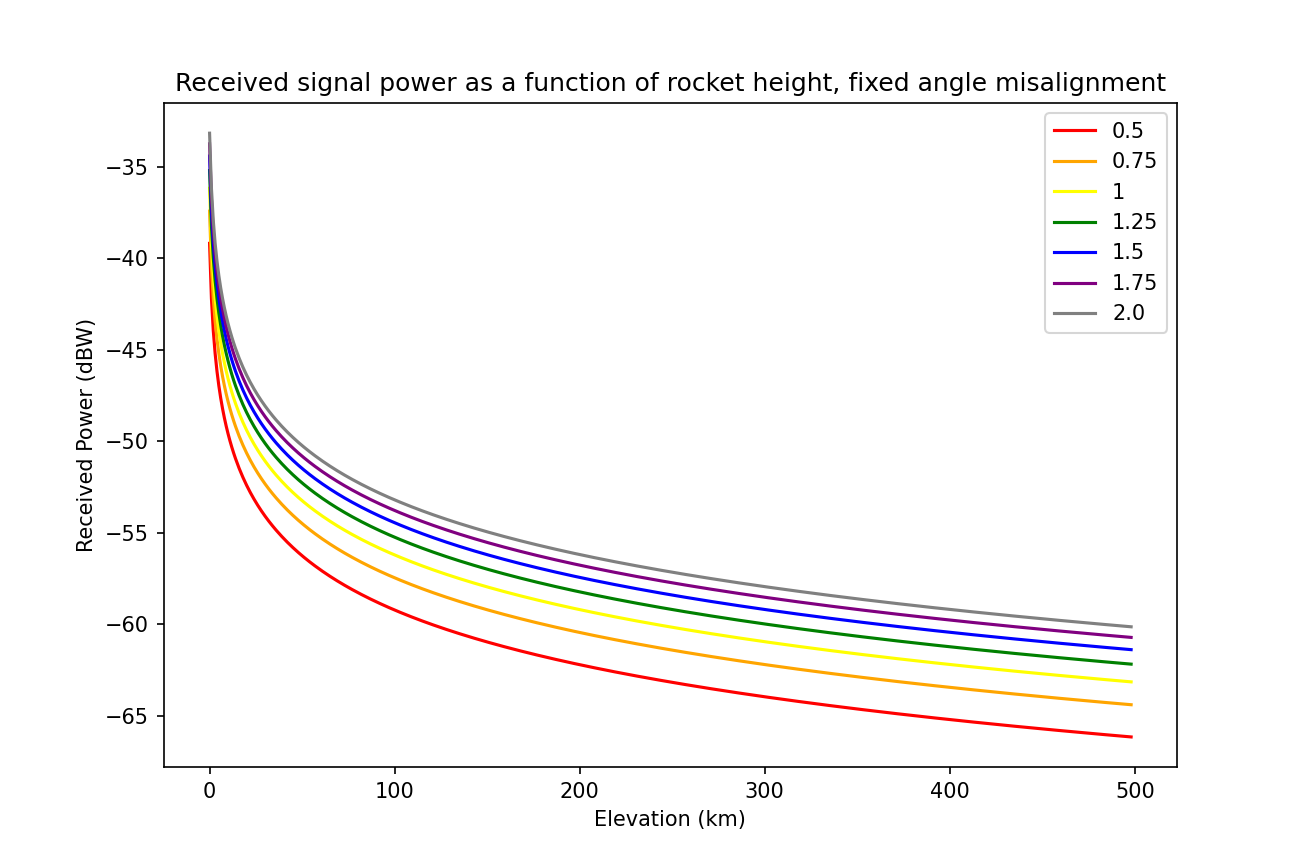

In [14]:
plt.close()
for index, series in enumerate(received_array):
    plt.plot(series, color=colors[index % len(colors)], label=f'Series {index + 1}')
plt.title("Received signal power as a function of rocket height, fixed angle misalignment")
plt.xlabel("Elevation (km)")
plt.ylabel("Received Power (dBW)")
plt.legend(power_array)
plt.show()

In [18]:
## Same idea as examining the effects of changing height along the trajectory -- look at the misalignment between rx and tx antennas and examine dependence 

## resetting height parameters to top of the trajectory
ht_rocket=500.0
Rrocket = ht_rocket*1.0e3
if Rrocket_mod is None: R=Rrocket  
Lpath = (4.*np.pi*R*freq/c_speed)

# Changing RX angle misalignmnent
angle_array = []
for n in range(0,90,1):
    angle_array.append(n)

received_array = []

for level_pwr in power_array:
    received_array_element = []
    for x in angle_array:
        rxAng = x
        txPwr = level_pwr
        Pwr_rx = (txPwr*(10.0**(Gtx/10.)*np.cos(txAng*np.pi/180.)**2)*(10.0**(Grx/10.)*np.cos(rxAng*np.pi/180.)**2))/Lpath # Received Power in Watts at input to receiver (i.e. without LNA gain)
        #print(Pwr_rx)
        received_array_element.append(10*np.log10(Pwr_rx))
    received_array.append(received_array_element)

<IPython.core.display.Javascript object>


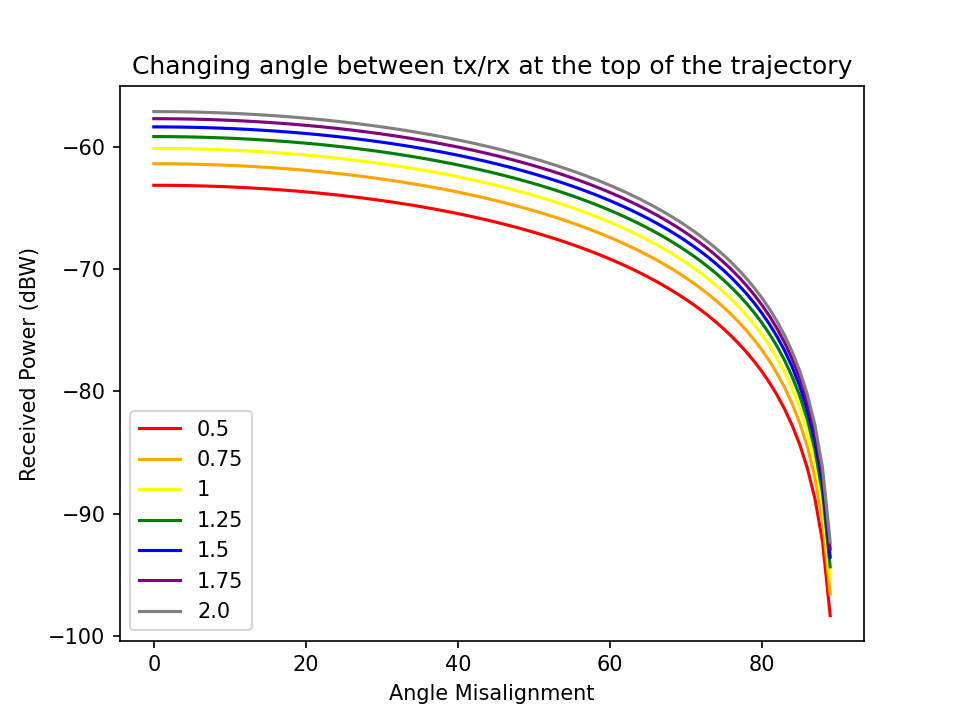

Text(0.5, 1.0, 'Changing angle between tx/rx at the top of the trajectory')

In [19]:
plt.close()
for index, series in enumerate(received_array):
    plt.plot(series, color=colors[index % len(colors)], label=f'Series {index + 1}')
plt.xlabel("Angle Misalignment")
plt.ylabel("Received Power (dBW)")
plt.legend(power_array)
plt.title("Changing angle between tx/rx at the top of the trajectory")

# Loading Trajectory + Receiving Site Information - Shreya

In [3]:
# Trajectory path 
trajectoryrt = np.genfromtxt("Traj_Right.txt", skip_header=1, dtype=float)

# Read the header separately
with open('Traj_Right.txt', 'r') as file:
    headers = file.readline().strip().split()

# Create arrays for each column using the header titles
traj_arraysrt = {header: trajectoryrt[:, i] for i, header in enumerate(headers)}

for title, array in traj_arraysrt.items():
    title = title + "_rttraj"
#     print(f"{title}: {array}")
# print(traj_arrays)

In [4]:
# Same for left trajectory
trajectorylf = np.genfromtxt("Traj_Left.txt", skip_header=1, dtype=float)
# Read the header separately
with open('Traj_Right.txt', 'r') as file:
    headers = file.readline().strip().split()

# Create arrays for each column using the header titles
traj_arrayslf = {header: trajectorylf[:, i] for i, header in enumerate(headers)}

for title, array in traj_arrayslf.items():
    title = title + "_rttraj"
#     print(f"{title}: {array}")
# print(traj_arrays)

In [5]:
# Receiving sites -- from SDR document
# PF == poker flat
lat_pf = 65.1192
long_pf = -147.43

# VT == venetie
lat_vt = 67.013
long_vt = -146.407

# BV == beaver
lat_bv = 66.36
long_bv = -147.4

# AV == arctic village 
lat_av = 68.113
long_av = -147.575
# TL == toolik
lat_tl = 68.627
long_tl = -149.598

# Distance + Az functions for ease of calculation along trajectory - Shreya

In [126]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points 
    on the Earth specified in decimal degrees of latitude and longitude.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula to calculate the distance
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of Earth in kilometers (mean radius)
    R = 6371.0

    # Calculate the distance
    distance = R * c
    return distance

def calculate_distance_and_azimuth(lat_ground, lon_ground, lat_air, lon_air, altitude):
    """
    Calculate the 3D distance and azimuthal angle between a ground point and an aerial point.
    """
    # Calculate horizontal (ground) distance using the Haversine formula
    horizontal_distance = haversine_distance(lat_ground, lon_ground, lat_air, lon_air)
    
    # Convert horizontal distance from kilometers to meters
    horizontal_distance_m = horizontal_distance * 1000

    # Calculate 3D distance using the Pythagorean theorem
    vertical_distance_m = altitude  # in meters
    distance_3d = np.sqrt(horizontal_distance_m**2 + vertical_distance_m**2)
    #calculate elevation angle
    elevation_angle = np.arctan2(vertical_distance_m, horizontal_distance_m)
    elevation_angle = np.degrees(elevation_angle)
    elevation_angle = (elevation_angle + 360) % 360
    #print(elevation_angle)
    # Calculate the azimuthal angle
    #dlon = np.radians(lon_air - lon_ground)
    #x = np.sin(dlon) * np.cos(np.radians(lat_air))
    #y = (np.cos(np.radians(lat_ground)) * np.sin(np.radians(lat_air)) -
    #     np.sin(np.radians(lat_ground)) * np.cos(np.radians(lat_air)) * np.cos(dlon))
    
    #azimuth = np.degrees(np.arctan2(x, y))
    #azimuth = (azimuth + 360) % 360  # Normalize the angle to be between 0 and 360

    return distance_3d, elevation_angle

lengthspf = []
lengthsvt = []
azspf = []
azsvt = []
times = []

for i, time in enumerate(traj_arraysrt["Time"]):
    latitude = traj_arraysrt["Latgd"][i]
    longitude = traj_arraysrt["Long"][i]
    altitude = traj_arraysrt["Altkm"][i]*1000
    time = traj_arraysrt["Time"][i]
#     print(f"Time: {time} sec - Latitude: {latitude} - Longitude: {longitude} - Altitude: {altitude}")
    lpf, azpf = calculate_distance_and_azimuth(lat_pf, long_pf, latitude, longitude, altitude)
    lvt, azvt = calculate_distance_and_azimuth(lat_vt, long_vt, latitude, longitude, altitude)
    lengthspf.append(lpf)
    lengthsvt.append(lvt)
    azspf.append(float(azpf))
    azsvt.append(float(azvt))
    times.append(float(time))

# print(lengths)
# print(azs)

# Spherical Coordinates - Sean

In [6]:
import numpy as np

# Constants
R_EARTH = 6371000  # Earth radius in meters

# Convert spherical to Cartesian coordinates
def spherical_to_cartesian(r, theta, phi):
	x = r * np.sin(theta) * np.cos(phi)
	y = r * np.sin(theta) * np.sin(phi)
	z = r * np.cos(theta)
	return np.array([x, y, z])

# Convert Cartesian to spherical coordinates
def cartesian_to_spherical(x, y, z):
	r = np.sqrt(x**2 + y**2 + z**2)
	theta = np.arcsin(z / r)  # Polar angle
	phi = np.arctan2(y, x)    # Azimuthal angle
	return np.array([r, theta, phi])

# Translate a point in spherical coordinates relative to a reference point
def translate_point_spherical(r1, theta1, phi1, r2, theta2, phi2):
	# Convert reference point and satellite point to Cartesian
	p1_cartesian = spherical_to_cartesian(r1, theta1, phi1)
	p2_cartesian = spherical_to_cartesian(r2, theta2, phi2)
	# Calculate the translated Cartesian coordinates
	translated_cartesian = p2_cartesian - p1_cartesian
	# Convert back to spherical coordinates
	return cartesian_to_spherical(*translated_cartesian)



# Initialize arrays
radiipf, radiivt, thetaspf, thetasvt, phispf, phisvt, times = [], [], [], [], [], [], []
radiitl, thetastl, phistl = [], [], []
# Process trajectory data
for i, time in enumerate(traj_arraysrt["Time"]):
	latitude = traj_arraysrt["Latgd"][i]
	longitude = traj_arraysrt["Long"][i]
	altitude = traj_arraysrt["Altkm"][i] * 1000  # Convert altitude to meters
	time = traj_arraysrt["Time"][i]
	
	# Poker Flat as origin
	rpf, tpf, ppf = translate_point_spherical(
	    R_EARTH, np.pi/2 - np.radians(lat_pf), np.radians(long_pf),
	    R_EARTH + altitude, np.pi/2 - np.radians(latitude), np.radians(longitude)
	)
	radiipf.append(rpf)
	thetaspf.append(np.degrees(np.arcsin(altitude/rpf)))
	ppf = np.degrees(ppf)
	if ppf < 0:
		ppf += 180
	
	phispf.append(ppf)
	
	# Venetie as origin
	rvt, tvt, pvt = translate_point_spherical(
	    R_EARTH, np.pi/2 - np.radians(lat_vt), np.radians(long_vt),
	    R_EARTH + altitude, np.pi/2 - np.radians(latitude), np.radians(longitude)
	)
	radiivt.append(rvt)
	thetasvt.append(np.degrees(np.arccos(altitude/rvt)))
	pvt = np.degrees(pvt)
	if pvt < 0:
		pvt += 360
	phisvt.append(pvt)
	times.append(time)
	# Toolik as origin
	rtl, ttl, ptl = translate_point_spherical(
	    R_EARTH, np.pi/2 - np.radians(lat_tl), np.radians(long_tl),
	    R_EARTH + altitude, np.pi/2 - np.radians(latitude), np.radians(longitude)
	)
	radiitl.append(rtl)
	thetastl.append(np.degrees(np.arccos(altitude/rtl)))
	ptl = np.degrees(ptl)
	if ptl < 0:
		ptl += 360
	phistl.append(ptl)

# Examining Right Rocket Trajectory Received Power - Shreya

<IPython.core.display.Javascript object>


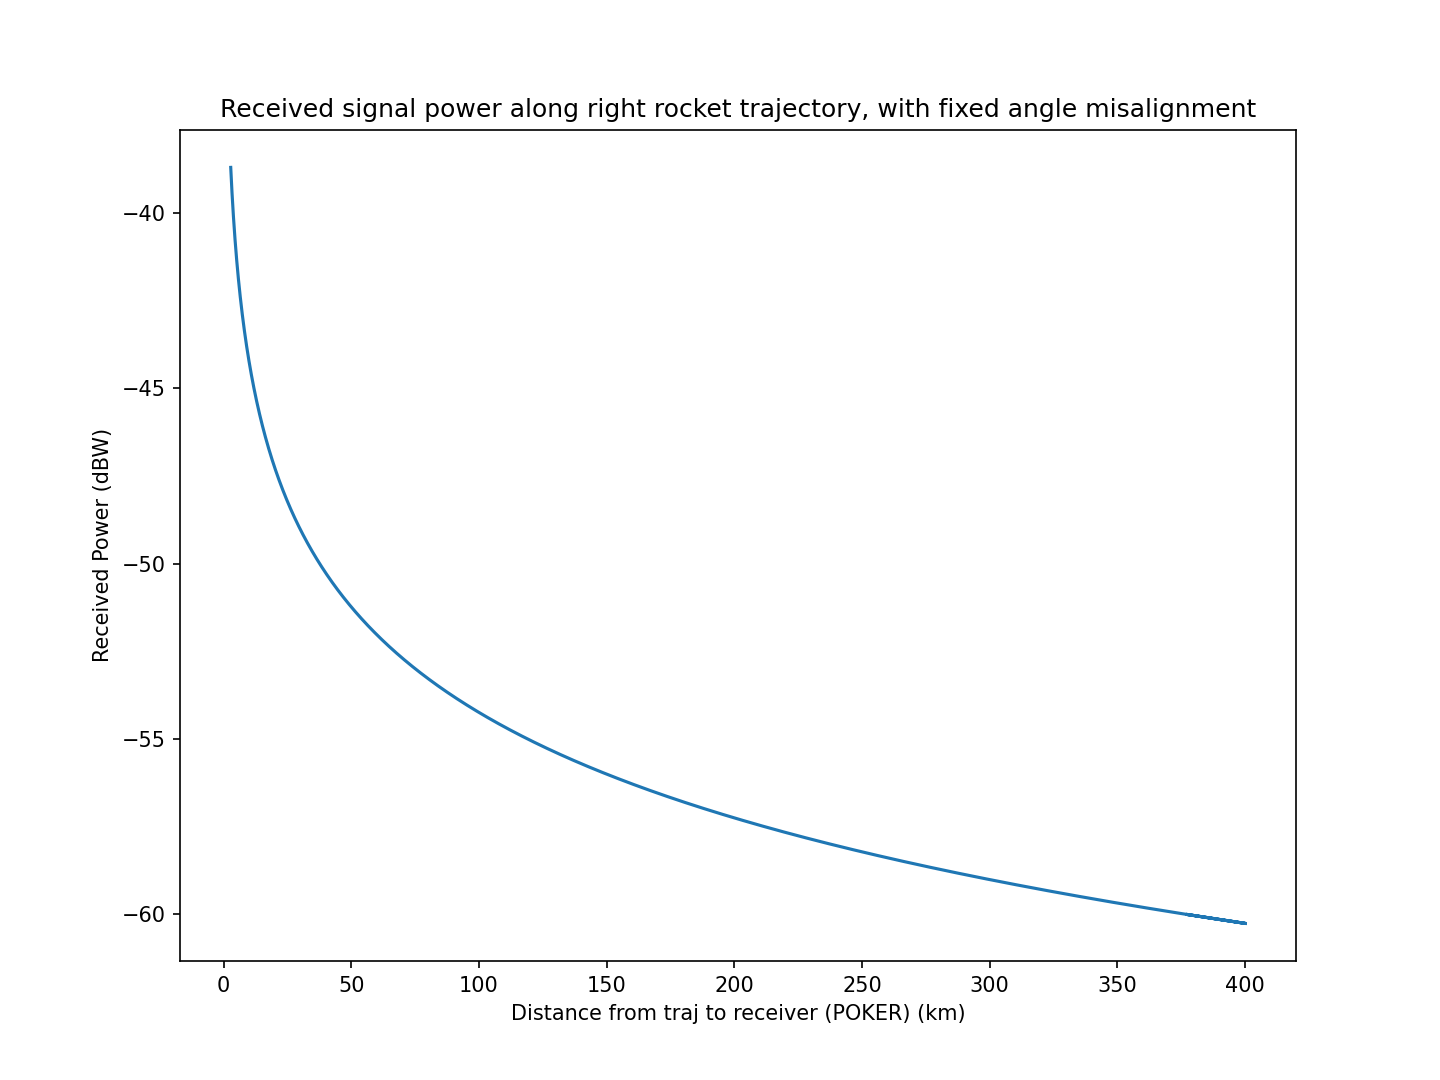

In [42]:
rxAng = 45
txAng = 45
received_array = []
lenx = []
# received power along the trajectory, if angle misalignment remained at 45/45 (i.e. 90)
for x in lengthspf:
    lenx.append(x/1000)
    ht_rocket = x/1000
    Rrocket = ht_rocket*1.0e3
    if Rrocket_mod is None: R=Rrocket
    Lpath = (4.*np.pi*R*freq/c_speed)
    Pwr_rx = (txPwr*(10.0**(Gtx/10.)*np.cos(txAng*np.pi/180.)**2)*(10.0**(Grx/10.)*np.cos(rxAng*np.pi/180.)**2))/Lpath # Received Power in Watts at input to receiver (i.e. without LNA gain)
    #print(Pwr_rx)
    received_array.append(10*np.log10(Pwr_rx))
    
plt.close()
plt.plot(lenx, received_array)
plt.title("Received signal power along right rocket trajectory, with fixed angle misalignment")
plt.xlabel("Distance from traj to receiver (POKER) (km)")
plt.ylabel("Received Power (dBW)")
plt.show()

In [66]:
# ALONG THE TRAJECTORY az + l dependence of signal received, With DBI VARIATION IN GAIN

# FIXED information
freq = 162.990625e6 # transmit frequency (Hz)
txPwr = 2 # transmit power in Watts
Gtx = 2.1 # dBi
Bn = 20e3
NFrx_dB = 0.5 #in dB with a pre-amp
NFrx = 10.0**(NFrx_dB/10) #Convert to dimensionless quantity

receivedpower = []
receivedcn = []
lenx = []

power_array = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2.0]
for length, az in zip(lengthspf, azspf):
        ht_rocket = length/1000
        lenx.append(ht_rocket)
        

for level_pwr in power_array:
    receivedpower_element = [] 
    receivedcn_element = []
    
    for length, az in zip(lengthspf, azspf):
        ht_rocket = length/1000
        
        txPwr = level_pwr 
        # GAIN of receiver dependent on azimuthal angle!
        Grx = 6.09 + 10*np.log10(cubic_spline(az))
        
        rxAng = az
        txAng = rxAng

        # Line-of-sight path length from tx to rx in meters
        Rrocket = ht_rocket*1.0e3; Rrocket_mod=None
        if Rrocket_mod is None: R=Rrocket
        else: R=Rrocket_mod

        # Path Loss
        Lpath = (4.*np.pi*R*freq/c_speed)**2 
        # Received Power 
        Pwr_rx = (txPwr*(10.0**(Gtx/10.)*np.cos(txAng*np.pi/180.)**2)*(10.0**(Grx/10.)*np.cos(rxAng*np.pi/180.)**2))/Lpath

        ## Calculations to find the Carrier-to-Noise Ratio
        # Calculate Noise temperature of reciever (asssuming reference temperature of 290K) [See Sat Comm book p. 111]
        Tn = 290*(NFrx-1) 
        # Calculate the Carrier-to-Noise Ratio
        CNR = Pwr_rx/(kB*Bn*Tn)
        
        # append power in dB
        receivedpower_element.append(10*np.log10(Pwr_rx))
        receivedcn_element.append(CNR)

    receivedpower.append(receivedpower_element)
    receivedcn.append(receivedcn_element)

<ipython-input-66-d9ac299c2ae2>:30: RuntimeWarning: invalid value encountered in log10
  Grx = 6.09 + 10*np.log10(cubic_spline(az))


<IPython.core.display.Javascript object>


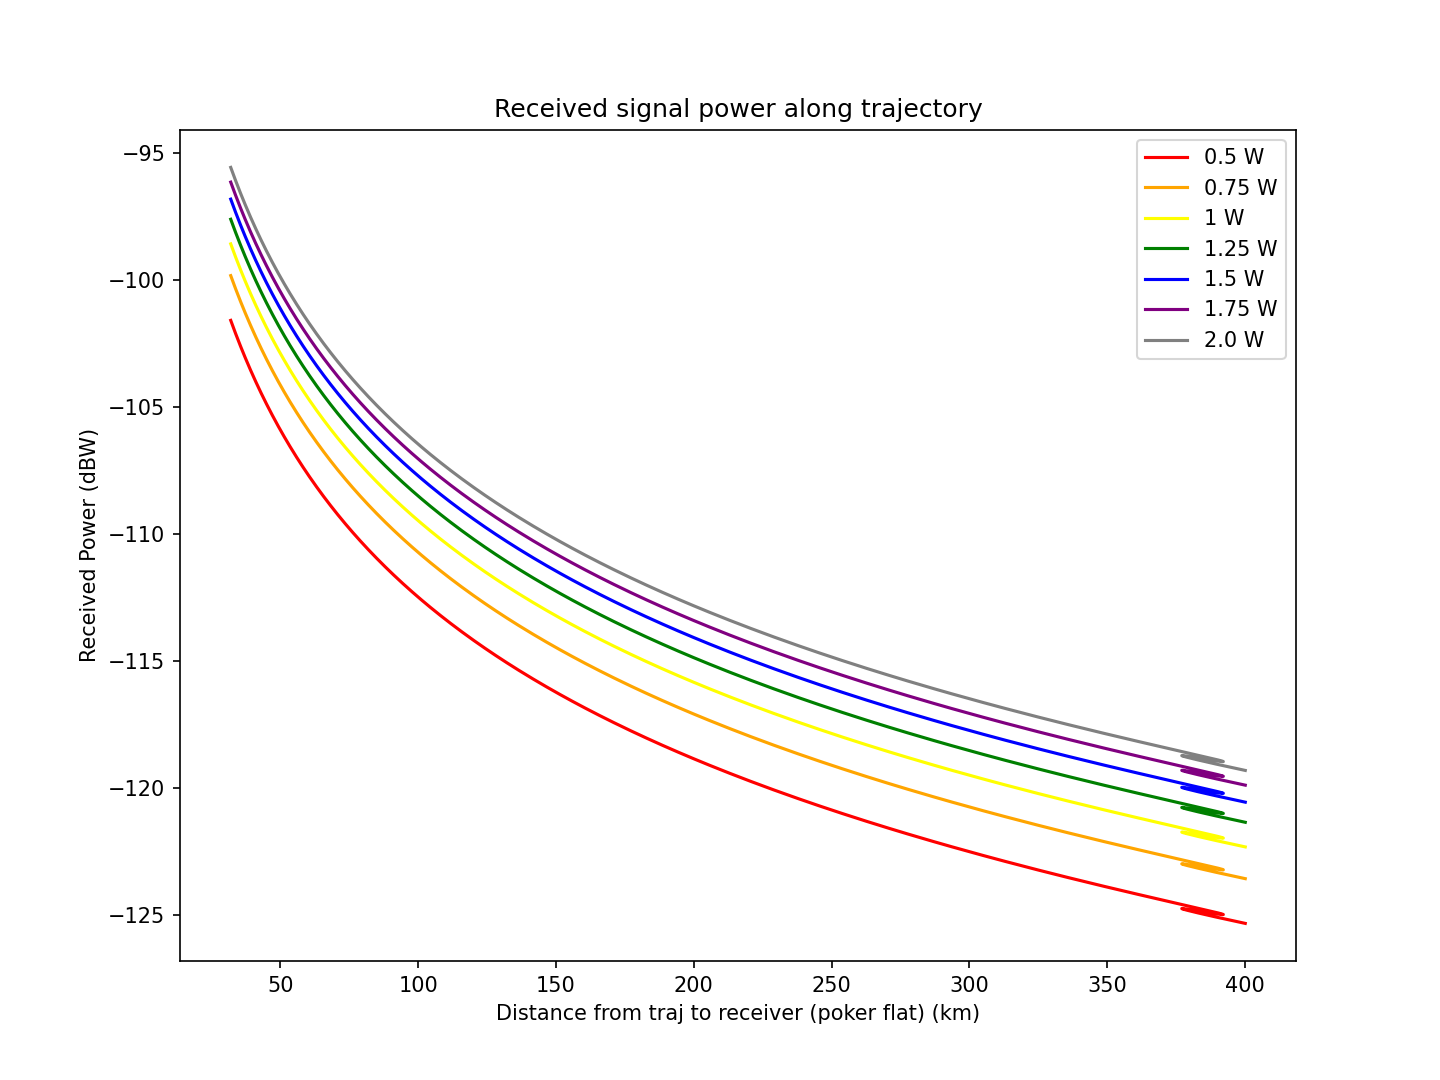

In [68]:
plt.close()
for index, series in enumerate(receivedpower):
    plt.plot(lenx, series, color=colors[index % len(colors)], label=f'Series {index + 1}')

plt.title("Received signal power along trajectory")
plt.xlabel("Distance from traj to receiver (poker flat) (km)")
plt.ylabel("Received Power (dBW)")
plt.legend([f'{pwr} W' for pwr in power_array])
plt.show()

<IPython.core.display.Javascript object>


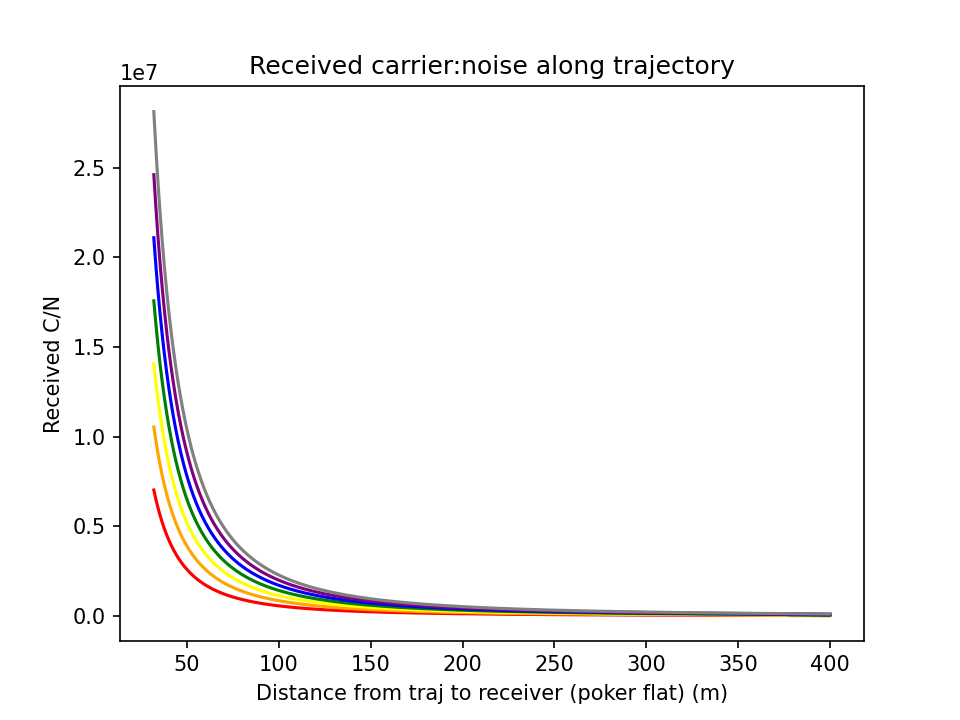

Text(0, 0.5, 'Received C/N')

In [69]:
plt.close()
for index, series in enumerate(receivedcn):
    plt.plot(lenx, series, color=colors[index % len(colors)], label=f'Series {index + 1}')
plt.title("Received carrier:noise along trajectory")
plt.xlabel("Distance from traj to receiver (poker flat) (m)")
plt.ylabel("Received C/N")

# 9/24 Link Margin Calcs - Sean

## Coordinate Plots

### Distance vs Time

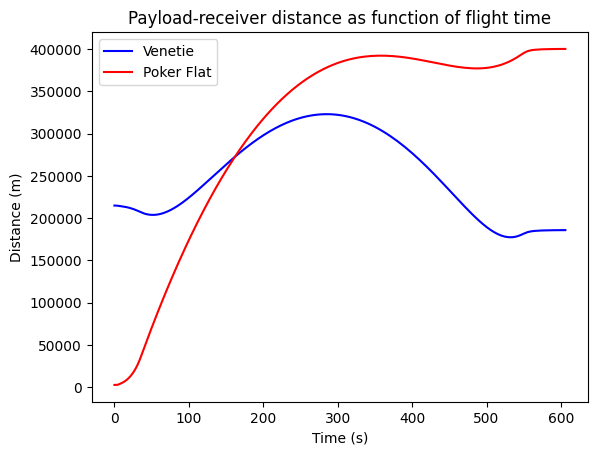

In [112]:
plt.close()
plt.plot(times, lengthsvt, label="Venetie", color='blue')
plt.plot(times, lengthspf, label="Poker Flat", color='red')
plt.title("Payload-receiver distance as function of flight time")
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.legend()

### Elevation Angle vs Time

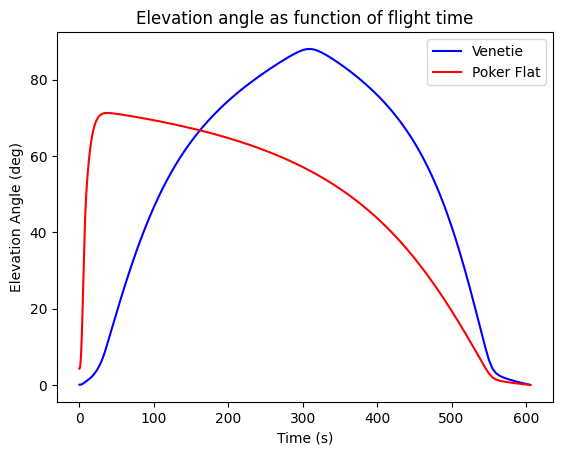

In [113]:
plt.close()
plt.plot(times, azsvt, label="Venetie", color='blue')
plt.plot(times, azspf, label="Poker Flat", color='red')
plt.title("Elevation angle as function of flight time")
plt.xlabel("Time (s)")
plt.ylabel("Elevation Angle (deg)")
plt.legend()

## Signal Plots

### Signal Strength, Distance Dependence Only

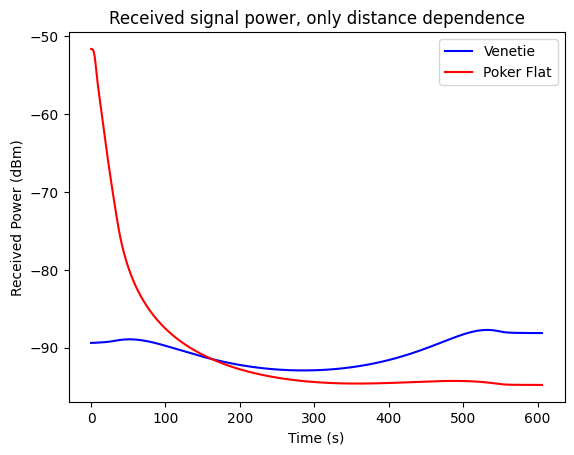

In [108]:
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant

# Placeholder for received power and lengths
receivedpower = []
lenx = []

# Assuming lengthsvt and azsvt are provided
# For each pair of length and azimuth
for length, az in zip(lengthsvt, azsvt):
    ht_rocket = length / 1000  # Convert length to kilometers
    lenx.append(ht_rocket)  # Store the length

    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Gain of receiver dependent on azimuthal angle (assuming cubic_spline function)
    Grx = 6.09 + 10 * np.log10(cubic_spline(45))

    # Line-of-sight path length from tx to rx in meters
    Rrocket = ht_rocket * 1.0e3  # Convert to meters

    # Path loss calculation
    Lpath = (4.0 * np.pi * Rrocket * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * (10.0 ** (Gtx / 10.0)) * (10.0 ** (Grx / 10.0))) / Lpath

    # Convert to dBW (log scale)
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpower.append(Pwr_rx_dBW+30)
receivedpowerpf = []
lenxpf = []

# Assuming lengthsvt and azsvt are provided
# For each pair of length and azimuth
for length, az in zip(lengthspf, azspf):
    ht_rocket = length / 1000  # Convert length to kilometers
    lenxpf.append(ht_rocket)  # Store the length

    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Gain of receiver dependent on azimuthal angle (assuming cubic_spline function)
    Grx = 6.09 + 10 * np.log10(cubic_spline(45))

    # Line-of-sight path length from tx to rx in meters
    Rrocket = ht_rocket * 1.0e3  # Convert to meters

    # Path loss calculation
    Lpath = (4.0 * np.pi * Rrocket * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * (10.0 ** (Gtx / 10.0)) * (10.0 ** (Grx / 10.0))) / Lpath

    # Convert to dBW (log scale)
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowerpf.append(Pwr_rx_dBW+30)
plt.plot(times, receivedpower, color='blue', label='Venetie')
plt.plot(times, receivedpowerpf, color='red', label='Poker Flat')
plt.title("Received signal power, only distance dependence")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend()

### Signal Strength, angular dependence

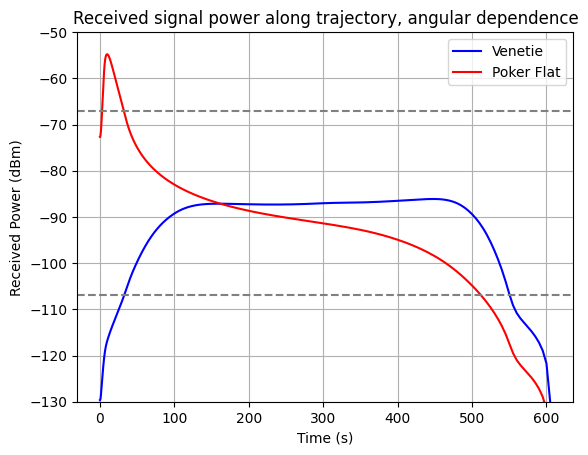

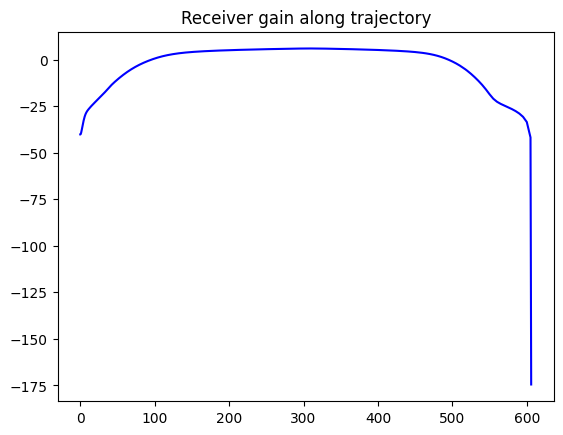

5.96995101203146
-174.52799739838872


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant

# Placeholder for received power and lengths
receivedpower = []
lenx = []
# Assuming lengthsvt and azsvt are provided
# For each pair of length and azimuth
for length, az in zip(lengthsvt, azsvt):
    ht_rocket = length / 1000  # Convert length to kilometers
    lenx.append(ht_rocket)  # Store the length

    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Gain of receiver dependent on azimuthal angle (assuming cubic_spline function)
    Grx = 6.09 + 10 * np.log10(cubic_spline(abs(90-az)))
    # Line-of-sight path length from tx to rx in meters
    Rrocket = ht_rocket * 1.0e3  # Convert to meters

    # Path loss calculation
    Lpath = (4.0 * np.pi * Rrocket * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * (10.0 ** (Gtx / 10.0)) * (10.0 ** (Grx / 10.0))) / Lpath

    # Convert to dBW (log scale)
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpower.append(Pwr_rx_dBW+30)
receivedpowerpf = []
lenxpf = []

# Assuming lengthsvt and azsvt are provided
# For each pair of length and azimuth
for length, az in zip(lengthspf, azspf):
    ht_rocket = length / 1000  # Convert length to kilometers
    lenxpf.append(ht_rocket)  # Store the length

    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Gain of receiver dependent on azimuthal angle (assuming cubic_spline function)
    Grx = 6.09 + 10 * np.log10(cubic_spline(abs(90-az)))

    # Line-of-sight path length from tx to rx in meters
    Rrocket = ht_rocket * 1.0e3  # Convert to meters

    # Path loss calculation
    Lpath = (4.0 * np.pi * Rrocket * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * (10.0 ** (Gtx / 10.0)) * (10.0 ** (Grx / 10.0))) / Lpath

    # Convert to dBW (log scale)
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowerpf.append(Pwr_rx_dBW+30)

# Now we plot the single series of received power against length
plt.plot(times, receivedpower, color='blue')
plt.plot(times, receivedpowerpf, color='red')

# Labels for the plot
plt.ylim(-130, -50)
plt.axhline(y=-107, color='gray', linestyle='--')
plt.axhline(y=-67, color='gray', linestyle='--')
plt.title("Received signal power along trajectory, angular dependence")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat"])
plt.grid(True)  # Adding grid for better visualization

# Display the plot
plt.show()

#-67, -107

### Signal power, ONLY angular dependence

In [116]:
print(np.mean(lengthspf))
print(np.mean(lengthsvt))

225391.62553426006
260187.56432670017


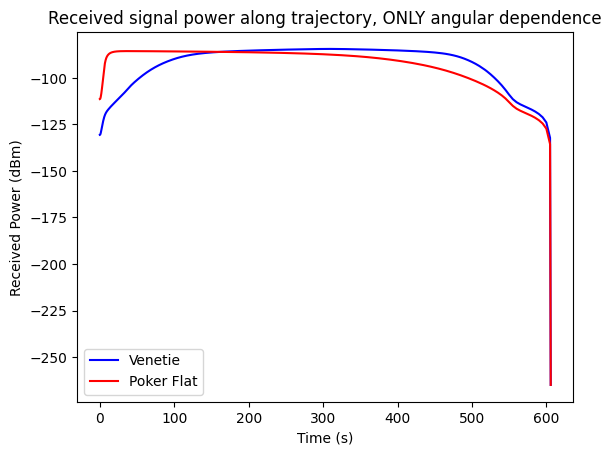

In [123]:
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant
Rrocket = 240000

# Placeholder for received power and lengths
receivedpower = []
lenx = []

# Assuming lengthsvt and azsvt are provided
# For each pair of length and azimuth
for length, az in zip(lengthsvt, azsvt):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Gain of receiver dependent on azimuthal angle (assuming cubic_spline function)
    Grx = 6.09 + 10 * np.log10(cubic_spline(az))

    # Line-of-sight path length from tx to rx in meters

    # Path loss calculation
    Lpath = (4.0 * np.pi * Rrocket * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * (10.0 ** (Gtx / 10.0)) * (10.0 ** (Grx / 10.0))) / Lpath

    # Convert to dBW (log scale)
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpower.append(Pwr_rx_dBW+30)
receivedpowerpf = []
lenxpf = []

# Assuming lengthsvt and azsvt are provided
# For each pair of length and azimuth
for length, az in zip(lengthspf, azspf):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Gain of receiver dependent on azimuthal angle (assuming cubic_spline function)
    Grx = 6.09 + 10 * np.log10(cubic_spline(az))

    # Line-of-sight path length from tx to rx in meters

    # Path loss calculation
    Lpath = (4.0 * np.pi * Rrocket * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * (10.0 ** (Gtx / 10.0)) * (10.0 ** (Grx / 10.0))) / Lpath

    # Convert to dBW (log scale)
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowerpf.append(Pwr_rx_dBW+30)

# Now we plot the single series of received power against length
plt.plot(times, receivedpower, color='blue')
plt.plot(times, receivedpowerpf, color='red')

# Labels for the plot
plt.title("Received signal power along trajectory, ONLY angular dependence")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat"])

### Modeling Angular Dependence

C:\Users\skwal\AppData\Local\Temp\ipykernel_16300\2048241314.py:14: RuntimeWarning: invalid value encountered in log10
  Grx = 6.09 + 10 * np.log10(cubic_spline(angle))


Text(0, 0.5, 'Received Power (dBm)')

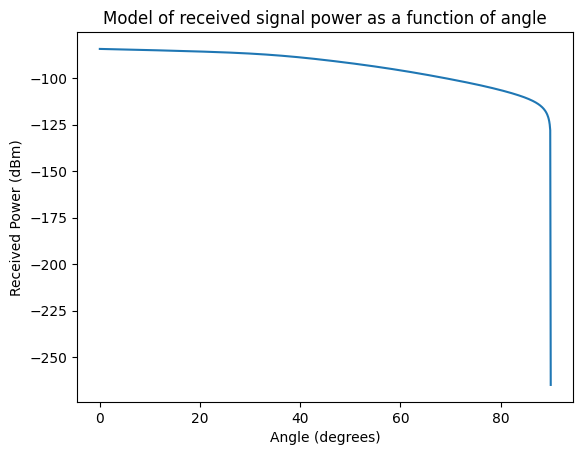

In [122]:
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant
Rrocket = 240000
angles = np.arange(0, 180.1, 0.1)

receivedpower = []
for angle in angles:
	txPwr = 1.5
	Grx = 6.09 + 10 * np.log10(cubic_spline(angle))
	Lpath = (4.0 * np.pi * Rrocket * freq / c_speed) ** 2
	Pwr_rx = (txPwr * (10.0 ** (Gtx / 10.0)) * (10.0 ** (Grx / 10.0))) / Lpath

    # Convert to dBW (log scale)
	Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
	receivedpower.append(Pwr_rx_dBW+30)
plt.plot(angles, receivedpower)
plt.title("Model of received signal power as a function of angle")
plt.xlabel("Angle (degrees)")
plt.ylabel("Received Power (dBm)")

# 11/24 Link Margin Calcs - Sean

### NEC2 Gain Interpolation

In [ ]:
import pandas as pd
from scipy.interpolate import RBFInterpolator as rbf
#documentation for interpolator - https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RBFInterpolator.html#scipy.interpolate.RBFInterpolator
# Get NEC data from excel spreadsheet
def data_from_excel(sheet_name):
	signal_data = pd.read_excel(sheet_name)
	# convert angle scales to match traj data
	signal_data['THETA']=signal_data['THETA'].abs()
	# convert complete loss value to avoid screwing up the interpolation
	signal_data.loc[signal_data['TOTAL']<=-900, 'TOTAL']=-20
	return(signal_data)

#rotate phi 90 degrees for N-S antenna
def rotate(signal_data):
	rotated_df = signal_data.copy()
	rotated_df['PHI'] = rotated_df['PHI'].apply(lambda x: x+90 if x<270 else x-270)
	return rotated_df
# Get interpolated function with Radial Basis Function 
def rbf_nec_data(signal_data):
	theta_vals = signal_data[['THETA']].to_numpy().flatten()
	phi_vals = signal_data[['PHI']].to_numpy().flatten()
	totals = signal_data['TOTAL'].to_numpy()
	interp = rbf(list(zip(theta_vals, phi_vals)), totals)
	return lambda thet, ph: interp(np.array([[thet, ph]])).item()


nec_data = data_from_excel('10152024_nec_data.xlsx')
ht15_nec_data = data_from_excel('15height_nec_data.xlsx')
ht2_nec_data = data_from_excel('2height_nec_data.xlsx')
# interpolate function from NEC data
rbf_f = rbf_nec_data(nec_data)
ht15_f = rbf_nec_data(ht15_nec_data)
ht2_f = rbf_nec_data(ht2_nec_data)

# gain calculations
vt_rbf = []
pf_rbf = []
tl_rbf = []
vt_ht15 = []
pf_ht15 = []
tl_ht15 = []
vt_ht2 = []
pf_ht2 = []
tl_ht2 = []

for phi, theta in zip(phisvt, thetasvt):
	vtr = rbf_f(theta, phi)
	vt_rbf.append(vtr)
	vt_ht15.append(ht15_f(theta, phi))
	vt_ht2.append(ht2_f(theta, phi))
for phi, theta in zip(phispf, thetaspf):
	pfr = rbf_f(theta, phi)
	pf_rbf.append(pfr)
	pf_ht15.append(ht15_f(theta, phi))
	pf_ht2.append(ht2_f(theta, phi))
for phi, theta in zip(phistl, thetastl):
	tlr = rbf_f(theta, phi)
	tl_rbf.append(tlr)
	tl_ht15.append(ht15_f(theta, phi))
	tl_ht2.append(ht2_f(theta, phi))


### Interpolation for N-S Antenna

In [67]:
rotated_ht15_nec_data = rotate(ht15_nec_data)
rotated_ht2_nec_data = rotate(ht2_nec_data)
vt_rotated_ht15 = []
vt_rotated_ht2 = []
pf_rotated_ht15 = []
pf_rotated_ht2 = []
tl_rotated_ht15 = []
tl_rotated_ht2 = []
for phi, theta in zip(phisvt, thetasvt):
	vt_rotated_ht15.append(ht15_f(theta, phi))
	vt_rotated_ht2.append(ht2_f(theta, phi))
for phi, theta in zip(phispf, thetaspf):
	pf_rotated_ht15.append(ht15_f(theta, phi))
	pf_rotated_ht2.append(ht2_f(theta, phi))
for phi, theta in zip(phistl, thetastl):
	tl_rotated_ht15.append(ht15_f(theta, phi))
	tl_rotated_ht2.append(ht2_f(theta, phi))

### double checking rotation function

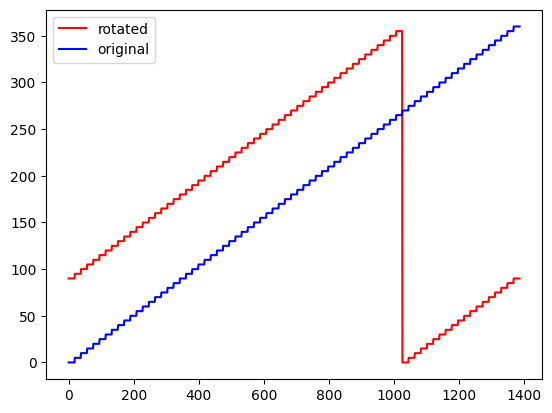

In [76]:
rotatedht15 = rotate(ht15_nec_data)
testphis = ht15_nec_data['PHI'].to_numpy().flatten()
testrotatedphis=rotatedht15['PHI'].to_numpy().flatten()
xaxis = np.linspace(0,len(testphis),len(testphis))
plt.plot(xaxis,testrotatedphis, label="rotated",color='red')
plt.plot(xaxis,testphis, label="original",color='blue')
plt.legend()

### Interpolation Contour Plot

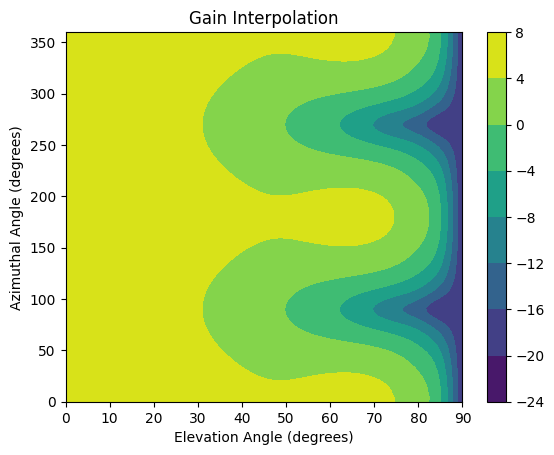

In [ ]:
theta_vals = nec_data[['THETA']].to_numpy().flatten()
phi_vals = nec_data[['PHI']].to_numpy().flatten()
totals = nec_data['TOTAL'].to_numpy()

from scipy.interpolate import RBFInterpolator as rbf
rbf_func = rbf(list(zip(theta_vals, phi_vals)), totals)
X = np.linspace(min(theta_vals), max(theta_vals), 100)
Y = np.linspace(min(phi_vals), max(phi_vals), 100)
X, Y = np.meshgrid(X, Y)
grid_points = np.c_[X.ravel(), Y.ravel()]
Z2 = rbf_func(grid_points)

# Reshape Z2 to the shape of X and Y
Z2 = Z2.reshape(X.shape)
plt.contourf(X, Y, Z2)
plt.colorbar()
plt.xlabel('Elevation Angle (degrees)')
plt.ylabel('Azimuthal Angle (degrees)')
plt.title('Gain Interpolation')
plt.show()



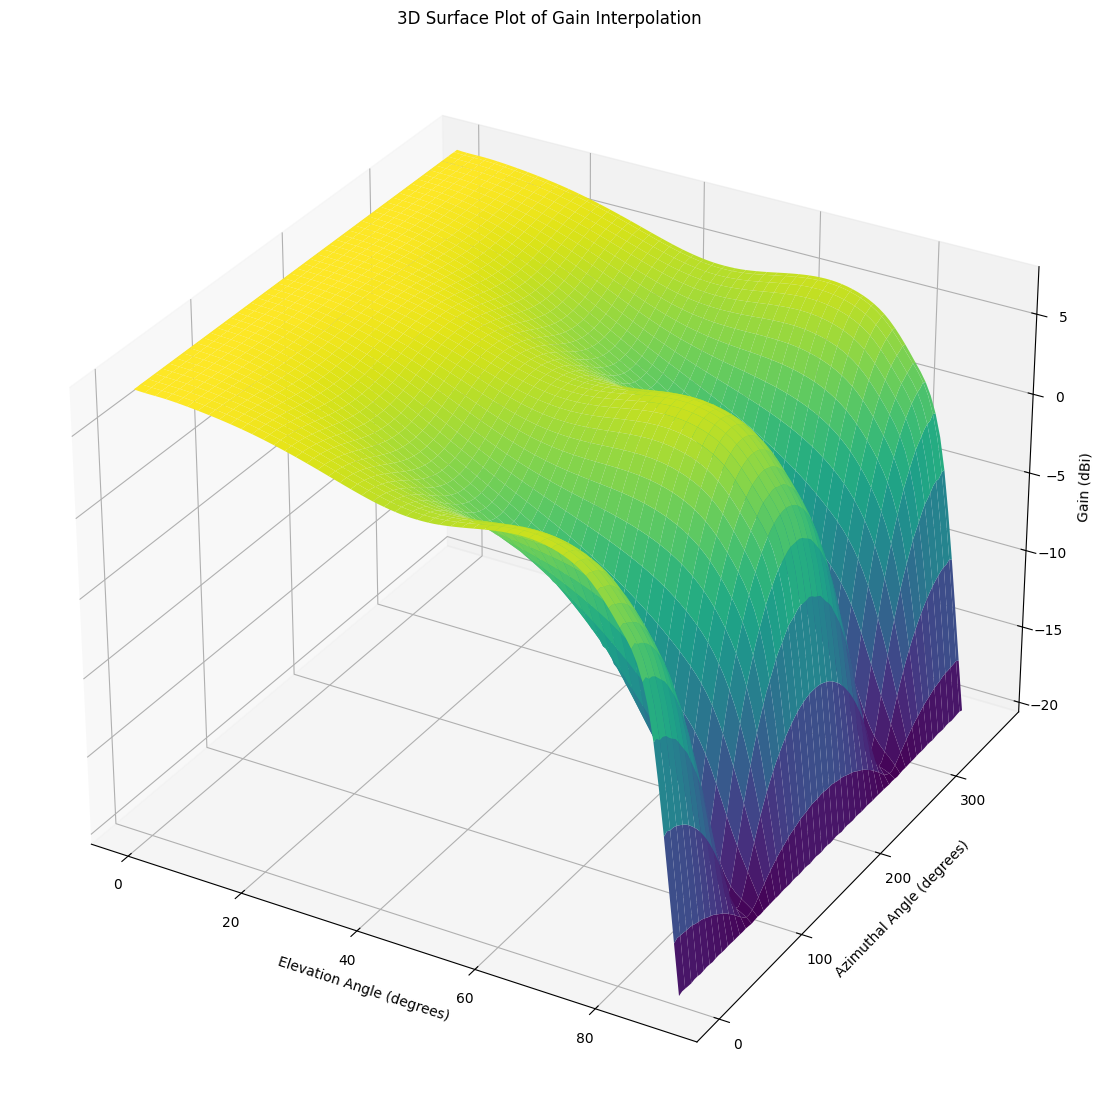

In [340]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z2, cmap='viridis')
ax.set_xlabel('Elevation Angle (degrees)')
ax.set_ylabel('Azimuthal Angle (degrees)')
ax.set_zlabel('Gain (dBi)')
plt.locator_params(axis='y', nbins=4)
plt.title('3D Surface Plot of Gain Interpolation')
plt.show()

## Link Margin Plots

### Coordinate Plots

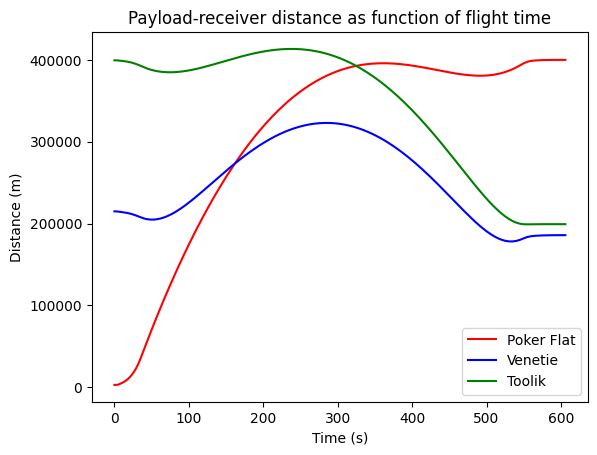

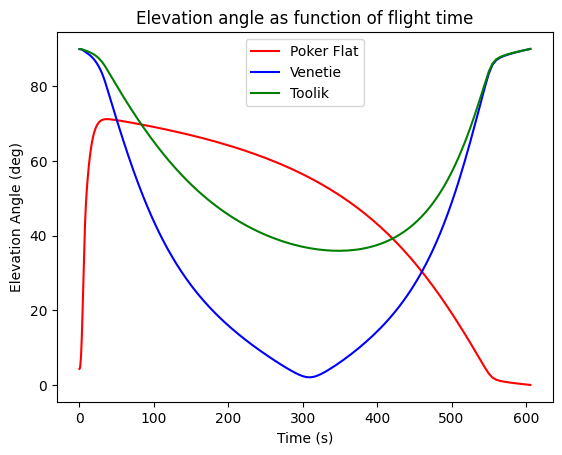

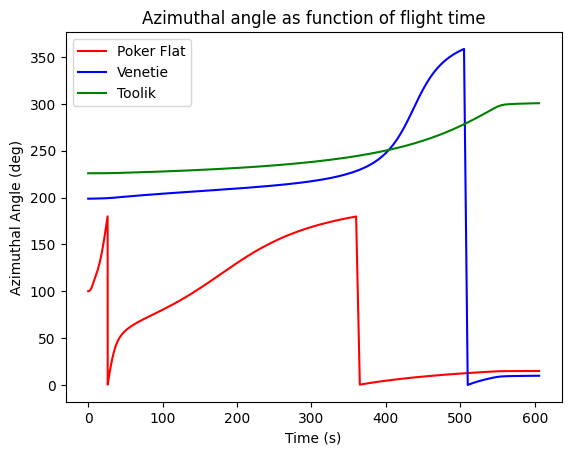

In [332]:
# Radius vs time
plt.plot(times, radiipf, label='Poker Flat', color='red')
plt.plot(times, radiivt, label='Venetie', color='blue')
plt.plot(times, radiitl, label='Toolik', color='green')
plt.title("Payload-receiver distance as function of flight time")
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.legend()
plt.show()
# Elevation angle vs time
plt.plot(times, thetaspf, label='Poker Flat', color='red')
plt.plot(times, thetasvt, label='Venetie', color='blue')
plt.plot(times, thetastl, label='Toolik', color='green')
plt.title("Elevation angle as function of flight time")
plt.xlabel("Time (s)")
plt.ylabel("Elevation Angle (deg)")
plt.legend()
plt.show()
# Azimuthal angle vs time
plt.plot(times, phispf, label='Poker Flat', color='red')
plt.plot(times, phisvt, label='Venetie', color='blue')
plt.plot(times, phistl, label='Toolik', color='green')
plt.title("Azimuthal angle as function of flight time")
plt.xlabel("Time (s)")
plt.ylabel("Azimuthal Angle (deg)")
plt.legend()
plt.show()


### Angular Dependence

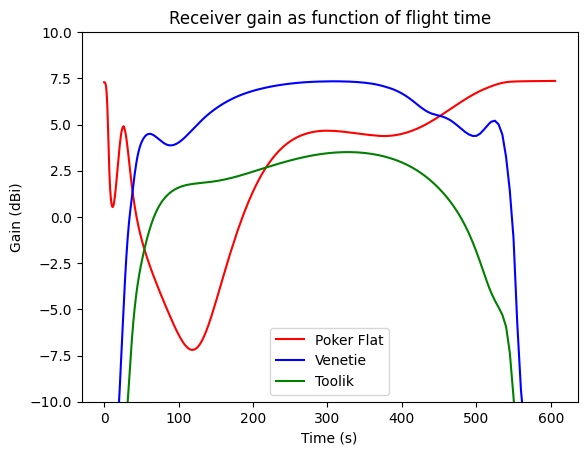

In [334]:
# Gain, angular dependence only
plt.plot(times, pf_rbf, label='Poker Flat', color='red')
plt.plot(times, vt_rbf, label='Venetie', color='blue')
plt.plot(times, tl_rbf, label='Toolik', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Gain (dBi)')
plt.ylim(-10,10)
plt.title('Receiver gain as function of flight time')
plt.legend()
plt.show()

### Radial Dependence

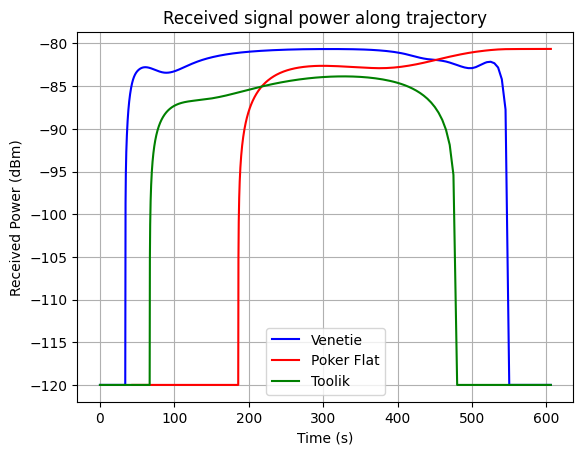

In [346]:
# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant
r = 240000
receivedpowervt = []
for radius, gain in zip(radiivt, vt_rbf):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * r * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowervt.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

receivedpowerpf = []
for radius, gain in zip(radiipf, pf_rbf):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * r * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowerpf.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm
receivedpowertl = []
for radius, gain in zip(radiitl, tl_rbf):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * r * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowertl.append(Pwr_rx_dBW+30)
#TEMP - remove signal jump at beginning of Poker Flat
# plot received power against trajectory
for i in range(np.argmin(receivedpowerpf)):
    receivedpowerpf[i] = np.nan
plt.plot(times, receivedpowervt, color='blue')
plt.plot(times, receivedpowerpf, color='red')
plt.plot(times, receivedpowertl, color='green')

# Labels for the plot
#plt.ylim(-130, -50)
#plt.axhline(y=-107, color='gray', linestyle='--')
#plt.axhline(y=-67, color='gray', linestyle='--')
plt.title("Received signal power along trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
plt.grid(True)  # Adding grid for better visualization

# Display the plot
plt.show()

### Radial and Angular Dependence

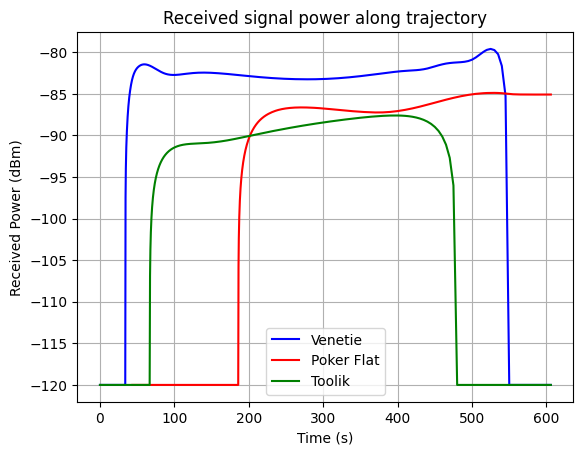

In [ ]:
# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant

receivedpowervt = []
for radius, gain in zip(radiivt, vt_rbf):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowervt.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

receivedpowerpf = []
for radius, gain in zip(radiipf, pf_rbf):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowerpf.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

receivedpowertl = []
for radius, gain in zip(radiitl, tl_rbf):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowertl.append(Pwr_rx_dBW+30)

#TEMP - remove signal jump at beginning of Poker Flat
for i in range(np.argmin(receivedpowerpf)):
    receivedpowerpf[i] = np.nan

#plot received power along trajectory
plt.plot(times, receivedpowervt, color='blue')
plt.plot(times, receivedpowerpf, color='red')
plt.plot(times, receivedpowertl, color='green')

# Labels for the plot
#plt.ylim(-130, -50)
#plt.axhline(y=-107, color='gray', linestyle='--')
#plt.axhline(y=-67, color='gray', linestyle='--')
plt.title("Received signal power along trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
plt.grid(True)  # Adding grid for better visualization

# Display the plot
plt.show()

### Height Comparisons

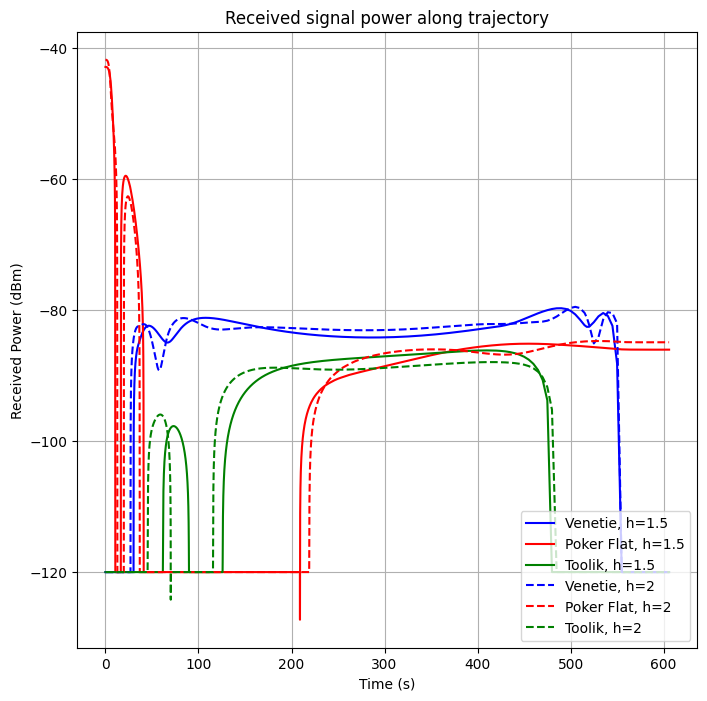

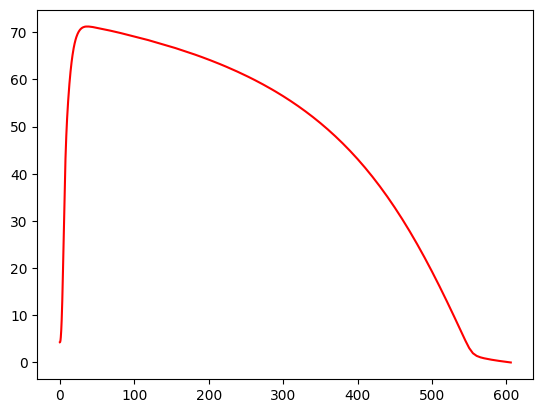

In [ ]:
%matplotlib inline
# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant

ht15vt = []
for radius, gain in zip(radiivt, vt_ht15):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15vt.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht15pf = []
for radius, gain in zip(radiipf, pf_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15pf.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht15tl = []
for radius, gain in zip(radiitl, tl_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15tl.append(Pwr_rx_dBW+30)


#ht=2
ht2vt = []
for radius, gain in zip(radiivt, vt_ht2):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht2vt.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht2pf = []
for radius, gain in zip(radiipf, pf_ht2):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht2pf.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht2tl = []
for radius, gain in zip(radiitl, tl_ht2):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht2tl.append(Pwr_rx_dBW+30)

#TEMP - remove signal jump at beginning of Poker Flat
#for i in range(np.argmax(thetaspf)+20):
#    ht15pf[i] = np.nan
#for i in range(np.argmax(thetaspf)+20):
#    ht2pf[i] = np.nan

plt.figure(figsize=(8,8))
#plot received power along trajectory
plt.plot(times, ht15vt, color='blue')
plt.plot(times, ht15pf, color='red')
plt.plot(times, ht15tl, color='green')
plt.plot(times, ht2vt, color='blue', linestyle='--')
plt.plot(times, ht2pf, color='red', linestyle='--')
plt.plot(times, ht2tl, color='green', linestyle='--')

# Labels for the plot
#plt.ylim(-130, -50)
#plt.axhline(y=-107, color='gray', linestyle='--')
#plt.axhline(y=-67, color='gray', linestyle='--')
plt.title("Received signal power along trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie, h=1.5", "Poker Flat, h=1.5", "Toolik, h=1.5", "Venetie, h=2", "Poker Flat, h=2", "Toolik, h=2"],loc='lower right')
plt.grid(True)  # Adding grid for better visualization

# Display the plot
plt.show()


### NS Height Comparison

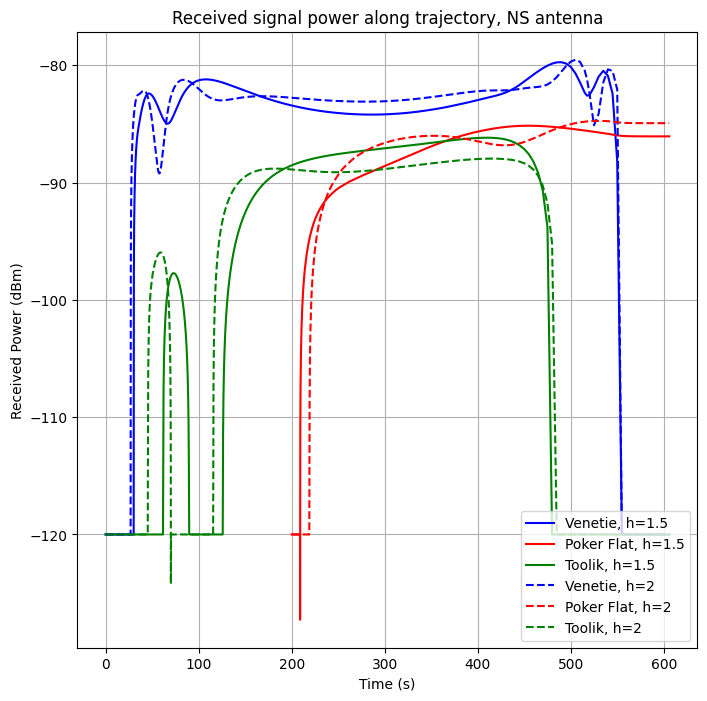

In [75]:
%matplotlib inline
# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant

ht15vt = []
for radius, gain in zip(radiivt, vt_rotated_ht15):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15vt.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht15pf = []
for radius, gain in zip(radiipf, pf_rotated_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15pf.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht15tl = []
for radius, gain in zip(radiitl, tl_rotated_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15tl.append(Pwr_rx_dBW+30)


#ht=2
ht2vt = []
for radius, gain in zip(radiivt, vt_rotated_ht2):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht2vt.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht2pf = []
for radius, gain in zip(radiipf, pf_rotated_ht2):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht2pf.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht2tl = []
for radius, gain in zip(radiitl, tl_rotated_ht2):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht2tl.append(Pwr_rx_dBW+30)

#TEMP - remove signal jump at beginning of Poker Flat
for i in range(np.where(np.array(times)==200)[0][0]):
    ht15pf[i] = np.nan
for i in range(np.where(np.array(times)==200)[0][0]):
    ht2pf[i] = np.nan

plt.figure(figsize=(8,8))
#plot received power along trajectory
plt.plot(times, ht15vt, color='blue')
plt.plot(times, ht15pf, color='red')
plt.plot(times, ht15tl, color='green')
plt.plot(times, ht2vt, color='blue', linestyle='--')
plt.plot(times, ht2pf, color='red', linestyle='--')
plt.plot(times, ht2tl, color='green', linestyle='--')

# Labels for the plot
#plt.ylim(-130, -50)
#plt.axhline(y=-107, color='gray', linestyle='--')
#plt.axhline(y=-67, color='gray', linestyle='--')
plt.title("Received signal power along trajectory, NS antenna")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie, h=1.5", "Poker Flat, h=1.5", "Toolik, h=1.5", "Venetie, h=2", "Poker Flat, h=2", "Toolik, h=2"],loc='lower right')
plt.grid(True)  # Adding grid for better visualization

# Display the plot
plt.show()


In [74]:
print(np.where(np.array(times)==200)[0][0])

2011
